# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [23]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [24]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [25]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [26]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [27]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [28]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [29]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]


array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [31]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8L, 27L)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [32]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]], dtype=int64)

In [33]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [34]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [35]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [36]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [37]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

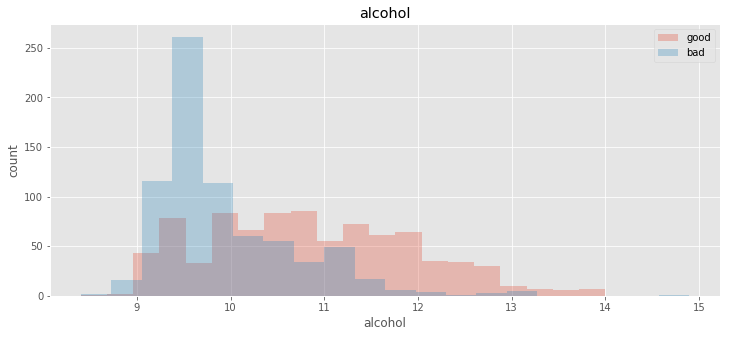

In [38]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [39]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values
print(y)

[0 0 0 ..., 1 0 1]


Далее вы увидете пример реализации этого простого классификатора.

In [40]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        print(min_error_rate)
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [41]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

0.295184490306
Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [42]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [43]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [45]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [46]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [47]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [137]:
from sklearn.base import ClusterMixin
from math import *

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        #задаём начальные центроиды и итерации цикла
        self.centroids = np.random.random((self.k,X.shape[1]))
        loop_range = np.arange(0,self.max_iter)
         
        #Цикл итераций
        for iter in loop_range:
            i = 0
            new_centroids = np.zeros((self.k, X.shape[1]))
            elem_count_per_clust = np.zeros(self.k)
            
            while i < X.shape[0]:
                clust_n = 0
                min_dist = sqrt(sum((self.centroids[clust_n]-X[i])**2))
                self.labels[i] = clust_n
                clust_n += 1
                
                while clust_n < self.k:
                    eucl_dist = 0
                    eucl_dist = sqrt(sum((self.centroids[clust_n]-X[i])**2))
                    
                    if eucl_dist < min_dist:
                        min_dist = eucl_dist 
                        self.labels[i] = clust_n
                        
                    clust_n += 1
            
                elem_count_per_clust[self.labels[i]] += 1
                new_centroids[self.labels[i]] += X[i]
                i += 1
            
            #пересчитываем центроиды и считаем ихсмещение за шаг 
            clust_n = 0
            diff = np.zeros(self.k)
            while clust_n < self.k:
                if elem_count_per_clust[clust_n] != 0:
                    new_centroids[clust_n] /= elem_count_per_clust[clust_n]
                else:
                    new_centroids[clust_n] = self.centroids[clust_n]
                diff[clust_n] = sqrt(sum((self.centroids[clust_n] - new_centroids[clust_n])**2))
                clust_n += 1
            
            self.centroids = new_centroids
            
            #print("sum diff")
            #print(sum(diff))
            #print(iter)
            if sum(diff) < 0.01:
                print("kol-vo iteraciy")
                print(iter)
                break
            
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        if X.shape[1] != self.centroids.shape[1]:
            print("nepravilniy razmer ")
            return 0,0
        
        labels = np.empty(X.shape[0])
        elem_count_per_clust = np.zeros(self.k)
        i = 0
        
        #расставляем лейблы кластеров множесту Х по центроидам после обучения
        while i < X.shape[0]:
            clust_n = 0
            min_dist = sqrt(sum((self.centroids[clust_n]-X[i])**2))
            labels[i] = clust_n
            clust_n += 1
                
            while clust_n < self.k:
                eucl_dist = 0
                eucl_dist = sqrt(sum((self.centroids[clust_n]-X[i])**2))
                    
                if eucl_dist < min_dist:
                    min_dist = eucl_dist 
                    labels[i] = clust_n
                        
                clust_n += 1
            
            elem_count_per_clust[labels[i]] += 1
            i += 1
        
        print("kol-vo elementov")
        print(elem_count_per_clust)
        
        return labels, self.centroids

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

In [49]:
from sklearn.datasets import make_blobs


In [50]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

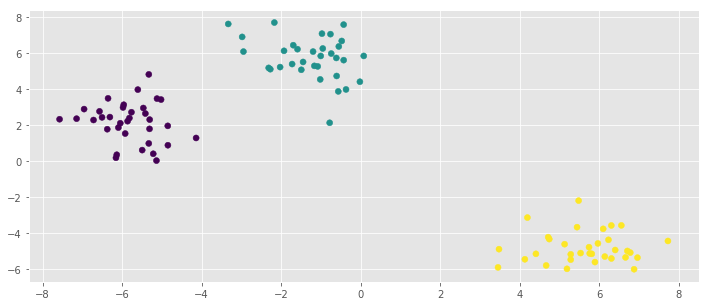

In [51]:
plt.scatter(X[:,0], X[:, 1], c=y)


#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

kol-vo iteraciy
3
kol-vo elementov
[ 33.  33.  34.]


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


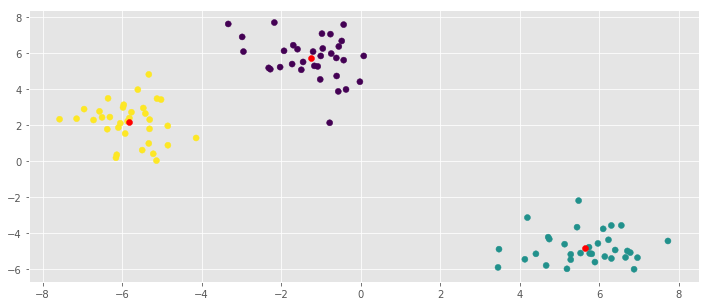

In [138]:
model = Kmeans(3)
model.fit(X)
y_hat, centroids= model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y_hat)
plt.scatter(centroids[:,0], centroids[:, 1], c="red")




# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [134]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()


,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [135]:
df_sns_36 = df_sns.iloc[:,4:].values
df_sns_36 = (df_sns_36 - df_sns_36.mean(axis=0))/df_sns_36.std(axis=0)



In [139]:
model_real = Kmeans(9)
model_real.fit(df_sns_36)
y_hat, centroids = model_real.predict(df_sns_36)


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


kol-vo iteraciy
61


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


kol-vo elementov
[   467.   1588.   4408.  18852.    748.    841.   1298.    895.    903.]


# Попробуем проинтерпретировать центроиды 

In [145]:
centroids

array([[  9.35499207e-02,   4.30360350e-02,   4.59443237e-03,
         -3.70660596e-03,  -5.97067895e-02,   5.89619187e-02,
          8.41974506e-04,  -5.33728441e-02,  -7.39247494e-03,
         -3.80217288e-02,  -3.41008289e-02,  -5.31727292e-03,
         -1.01108491e-01,  -5.46128009e-04,  -5.12678163e-02,
          2.66555896e-03,   9.77804722e-02,  -2.20796574e-02,
          2.76024876e-01,   1.19982805e-01,   3.13052731e+00,
          2.27764053e+00,   3.30812671e+00,   4.67770462e+00,
          2.07930243e-02,  -8.67831353e-03,   4.18735632e-03,
         -6.21403626e-02,   5.36500607e-02,   3.91923345e-02,
         -9.03262607e-02,  -1.06432865e-01,   2.77822529e-01,
          4.24811069e-01,   5.32199518e-02,   5.43992214e-02],
       [  1.34872526e+00,   2.20370934e+00,   4.99987254e-01,
          1.61874993e-02,   9.54945217e-03,   2.87134639e-02,
          1.23252730e-01,   1.94494973e+00,   7.69218219e-03,
          1.16933028e+00,  -5.62777804e-02,  -1.41651728e-03,
       

In [161]:
from pandas import DataFrame
dff = DataFrame(centroids, columns=df_sns.columns[4:])
dff.iloc[:,:18]


,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching
0,0.093550,0.043036,0.004594,-0.003707,-0.059707,0.058962,0.000842,-0.053373,-0.007392,-0.038022,-0.034101,-0.005317,-0.101108,-0.000546,-0.051268,0.002666,0.097780,-0.022080
1,1.348725,2.203709,0.499987,0.016187,0.009549,0.028713,0.123253,1.944950,0.007692,1.169330,-0.056278,-0.001417,0.016422,-0.068396,-0.085164,-0.039090,-0.076418,-0.106325
2,-0.006021,-0.040282,0.121784,-0.088078,-0.062223,0.411151,0.361747,-0.095370,-0.052101,-0.058524,0.781035,0.010066,0.346125,-0.012107,-0.016269,0.602272,-0.041696,-0.125602
3,-0.164423,-0.214690,-0.084446,-0.144224,-0.132260,-0.133896,-0.122465,-0.145324,-0.101435,-0.139961,-0.234292,-0.102738,-0.119528,-0.166600,-0.137750,-0.187944,-0.131604,-0.134956
4,-0.121223,0.004321,-0.067966,-0.058880,-0.123392,0.034830,-0.103354,-0.111443,-0.034461,-0.121168,-0.082477,-0.051919,-0.049653,-0.071700,-0.060879,0.013771,3.354174,4.836686
5,0.142110,0.203669,0.099372,-0.007345,0.103357,0.243731,0.416883,0.015387,0.093277,0.091597,0.383007,0.019997,0.117625,0.356193,0.063521,0.233643,-0.100930,-0.108286
6,0.047871,0.056267,0.038511,-0.060656,-0.040676,0.051485,0.053311,-0.066752,1.512124,-0.015826,0.262031,-0.014264,0.174623,2.150876,-0.071022,0.259864,0.011100,-0.109218
7,0.592524,0.172967,0.059232,3.526635,3.091976,0.118245,0.014258,0.090129,0.008292,0.440525,0.052960,-0.042180,-0.013483,0.055251,-0.049060,0.003341,-0.061063,-0.102502
8,0.354506,0.336260,0.137450,0.062036,0.079173,0.262699,0.182394,0.191558,0.122402,0.772512,0.482273,2.188168,0.525188,0.239634,3.274039,0.448733,0.395410,-0.017983


In [162]:
dff.iloc[:,18:36]

,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0.276025,0.119983,3.130527,2.277641,3.308127,4.677705,0.020793,-0.008678,0.004187,-0.062140,0.053650,0.039192,-0.090326,-0.106433,0.277823,0.424811,0.053220,0.054399
1,0.057484,0.236540,-0.034175,0.070153,-0.011867,-0.045780,0.004568,-0.110993,0.055083,-0.044982,-0.133498,-0.055717,-0.110679,-0.133474,-0.074972,-0.071224,-0.067357,-0.085602
2,0.302898,0.148893,0.077393,0.249952,0.006034,-0.086494,0.315391,-0.007426,0.020143,0.653889,0.922645,0.581803,-0.041706,-0.063630,0.069528,0.169429,0.038456,-0.049386
3,-0.163909,-0.128563,-0.115831,-0.142719,-0.082521,-0.083774,-0.227212,-0.169969,-0.031168,-0.217845,-0.282319,-0.223533,-0.160337,-0.152868,-0.100325,-0.092761,-0.093505,-0.113972
4,0.378008,0.152156,0.028820,0.000595,-0.036372,-0.045451,-0.057326,-0.002984,-0.014456,-0.131645,-0.092360,-0.059622,-0.166779,-0.144773,-0.027202,0.013937,-0.083068,-0.078176
5,0.145726,0.063313,0.003260,-0.016692,-0.029125,-0.051953,0.442534,0.142014,0.059259,0.600822,0.783199,0.578921,4.166973,4.015142,0.059351,0.084200,0.044748,0.041901
6,0.056776,0.051499,0.054512,0.134756,-0.017830,-0.059071,0.144204,2.176988,0.010148,0.222504,0.323114,0.122657,-0.083728,-0.067284,-0.007355,-0.018123,-0.011931,-0.067879
7,-0.024411,-0.007419,0.021259,0.113727,0.030157,-0.049648,0.036435,-0.008242,0.017519,0.084563,0.226841,0.064048,-0.014598,-0.027155,-0.076520,0.040318,-0.041237,-0.058492
8,1.195309,1.228725,0.356031,0.168507,0.056739,0.052686,2.579505,0.534201,0.378396,0.616940,0.260262,1.178351,0.184937,0.296301,1.797671,0.912346,1.941063,2.924444


# Интерпретация 
* 0-кластер - явно религиозная группа людей, интересы: библия, бог, церковь, вопросы смерти.
* 1-кластер - группа людей с основным интересом: спорт, бейсбол, баскетбол, футбол.
* 2-кластер - скорее всего молодые девушки любят: немного спорт, черлидинг, танцы, встречаются слова "милый", "секси" и любят магазины,шопинг, одежда(вряд ли прани)
* 3-кластер - активность по всем переменным примерна одинакова и чуть ниже среднего. Не имеют конкретных интересов, мало активны.
* 4-кластер - ярко выражено только "band" и "marching" возможно те кто устраивают всякие митинги и т.д.
* 5-кластер - шопоголики, модники. Интресы: причёска, шопинг, магазины и особенно так понимаю бренды одежды "abercrombie" и "hollister"
* 6-кластер - фигурируют не связанные интересы: Тенис, "hot", платья
* 7-кластер - Поклонники софтола и волейола.
* 8-кластер - супер активная группа людей практически по всем темам, возможно молодёжь, заинтересованность в спорте, затрагиваются темы "sex" и "поцелуи", слушает много музыки, увлекается модой(причёски, магазины, одежда, шопинг) + темы смерти, алкоголь, наркотики.
